In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Importando as bibliotecas

In [51]:
# Instalar as bibliotecas necessárias
!pip install requests pandas

# Importar as bibliotecas
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

##Montando o dataframe

In [52]:
# Definir a URL base da API para a busca dos item_ids
search_terms = ["playstation 5", "xbox one", "nintendo switch"]
base_url = "https://api.mercadolibre.com/sites/MLA/search?q={}&limit=50"

# Lista para armazenar todos os resultados
all_item_ids = []

# Fazer múltiplas requisições para obter até 200 itens por termo de busca
for term in search_terms:
    for offset in range(0, 200, 50):
        # Atualizar a URL com o termo de busca e o offset
        url = base_url.format(term) + f"&offset={offset}"

        # Fazer a requisição à API
        response = requests.get(url)

        # Verificar se a requisição foi bem-sucedida
        if response.status_code == 200:
            # Obter os dados em formato JSON
            data = response.json()

            # Extrair a lista de resultados
            results = data.get('results', [])

            # Adicionar os IDs dos resultados à lista total
            all_item_ids.extend([(item['id'], term) for item in results])
        else:
            print(f"Erro na requisição com offset {offset} para o termo '{term}': {response.status_code}")
            break

# Remover duplicatas de IDs
all_item_ids = list(set(all_item_ids))

# Lista para armazenar os dados dos itens
items = []

# URL base para obter detalhes do item
item_details_url = "https://api.mercadolibre.com/items/{}"

# Iterar sobre os IDs dos itens e obter os detalhes
for item_id, search_term in all_item_ids:
    # Fazer a requisição à API de detalhes do item
    response = requests.get(item_details_url.format(item_id))

    # Verificar se a requisição foi bem-sucedida
    if response.status_code == 200:
        # Obter os dados em formato JSON
        item = response.json()

        # Extrair as informações desejadas
        seller_address = item.get('seller_address', {})
        city_name = seller_address.get('city', {}).get('name')
        state_id = seller_address.get('state', {}).get('id')
        state_name = seller_address.get('state', {}).get('name')

        item_data = {
            'id': item.get('id'),
            'search_term': search_term,  # Adicionar o termo de busca
            'title': item.get('title'),
            'price': item.get('price'),
            'currency_id': item.get('currency_id'),
            'initial_quantity': item.get('initial_quantity'),
            'sold_quantity': item.get('sold_quantity'),
            'catalog_product_id': item.get('catalog_product_id'),
            'category_id': item.get('category_id'),
            'condition': item.get('condition'),
            'permalink': item.get('permalink'),
            'seller_city_name': city_name,
            'seller_state_id': state_id,
            'seller_state_name': state_name,
            'listing_type_id': item.get('listing_type_id'),
            'buying_mode': item.get('buying_mode'),
            'domain_id': item.get('domain_id'),
            'health': item.get('health'),
            'status': item.get('status'),
            'accepts_mercadopago': item.get('accepts_mercadopago')
        }
        items.append(item_data)
    else:
        print(f"Erro ao obter detalhes do item {item_id}: {response.status_code}")

# Criar um DataFrame a partir da lista de itens
df = pd.DataFrame(items)

# Salvar o DataFrame em um arquivo CSV no Google Drive
df.to_csv('/content/drive/My Drive/Case Meli/df_videogames.csv', index=False)

print("Dados salvos em '/content/drive/My Drive/Case Meli/df_videogames.csv'")


Dados salvos em '/content/drive/My Drive/Case Meli/df_videogames.csv'


##Primeiras análises

Tabela agregada por search_term:
       search_term  count_id     avg_price  sum_initial_quantity
0  nintendo switch       197  6.841051e+05                  2104
1    playstation 5       186  1.588623e+06                  9484
2         xbox one       199  4.602884e+05                  1323

Tabela agregada por seller_state_name:
      seller_state_name  count_id  avg_price_playstation_5  \
0          Buenos Aires       245             1.524490e+06   
1       Capital Federal       268             1.649281e+06   
2                Chubut         1                      NaN   
3               Córdoba        27             1.548753e+06   
4            Entre Ríos         2                      NaN   
5               Formosa         2                      NaN   
6                 Jujuy         1                      NaN   
7              La Pampa         1                      NaN   
8              La Rioja         1                      NaN   
9               Mendoza         9             1

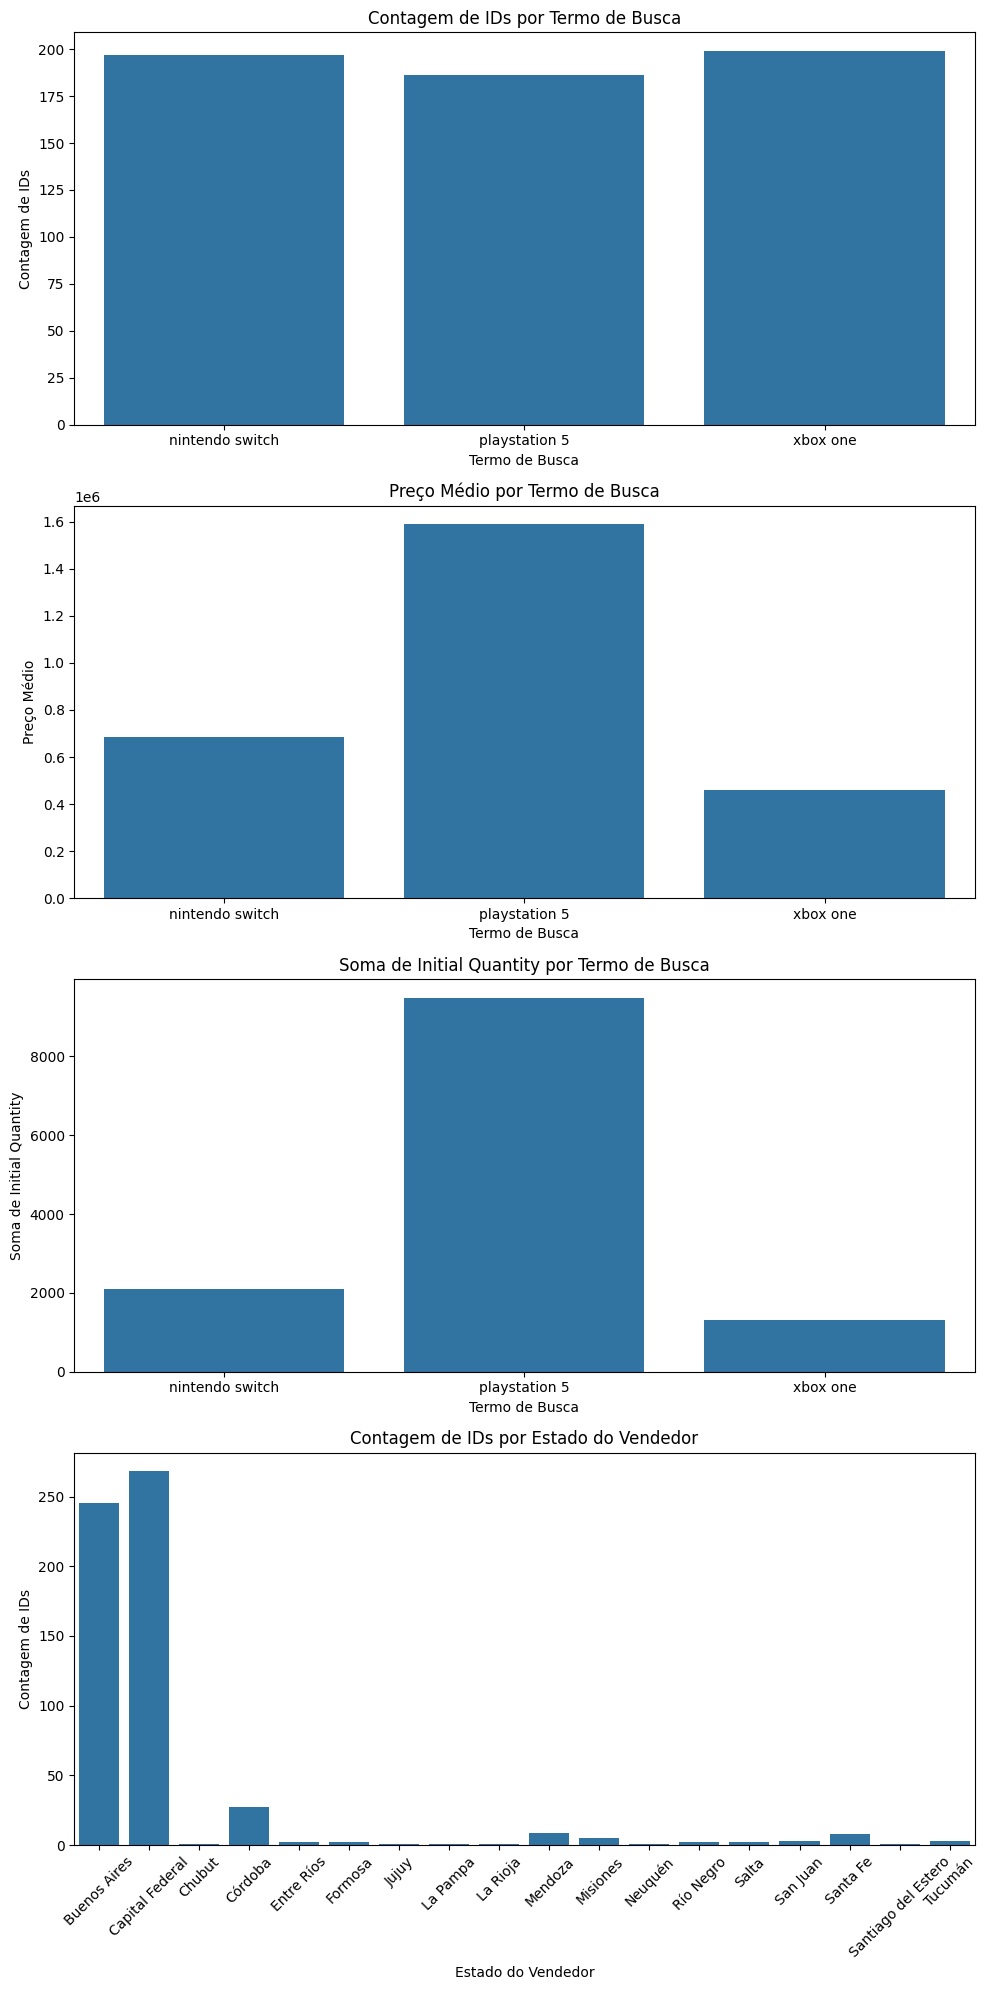

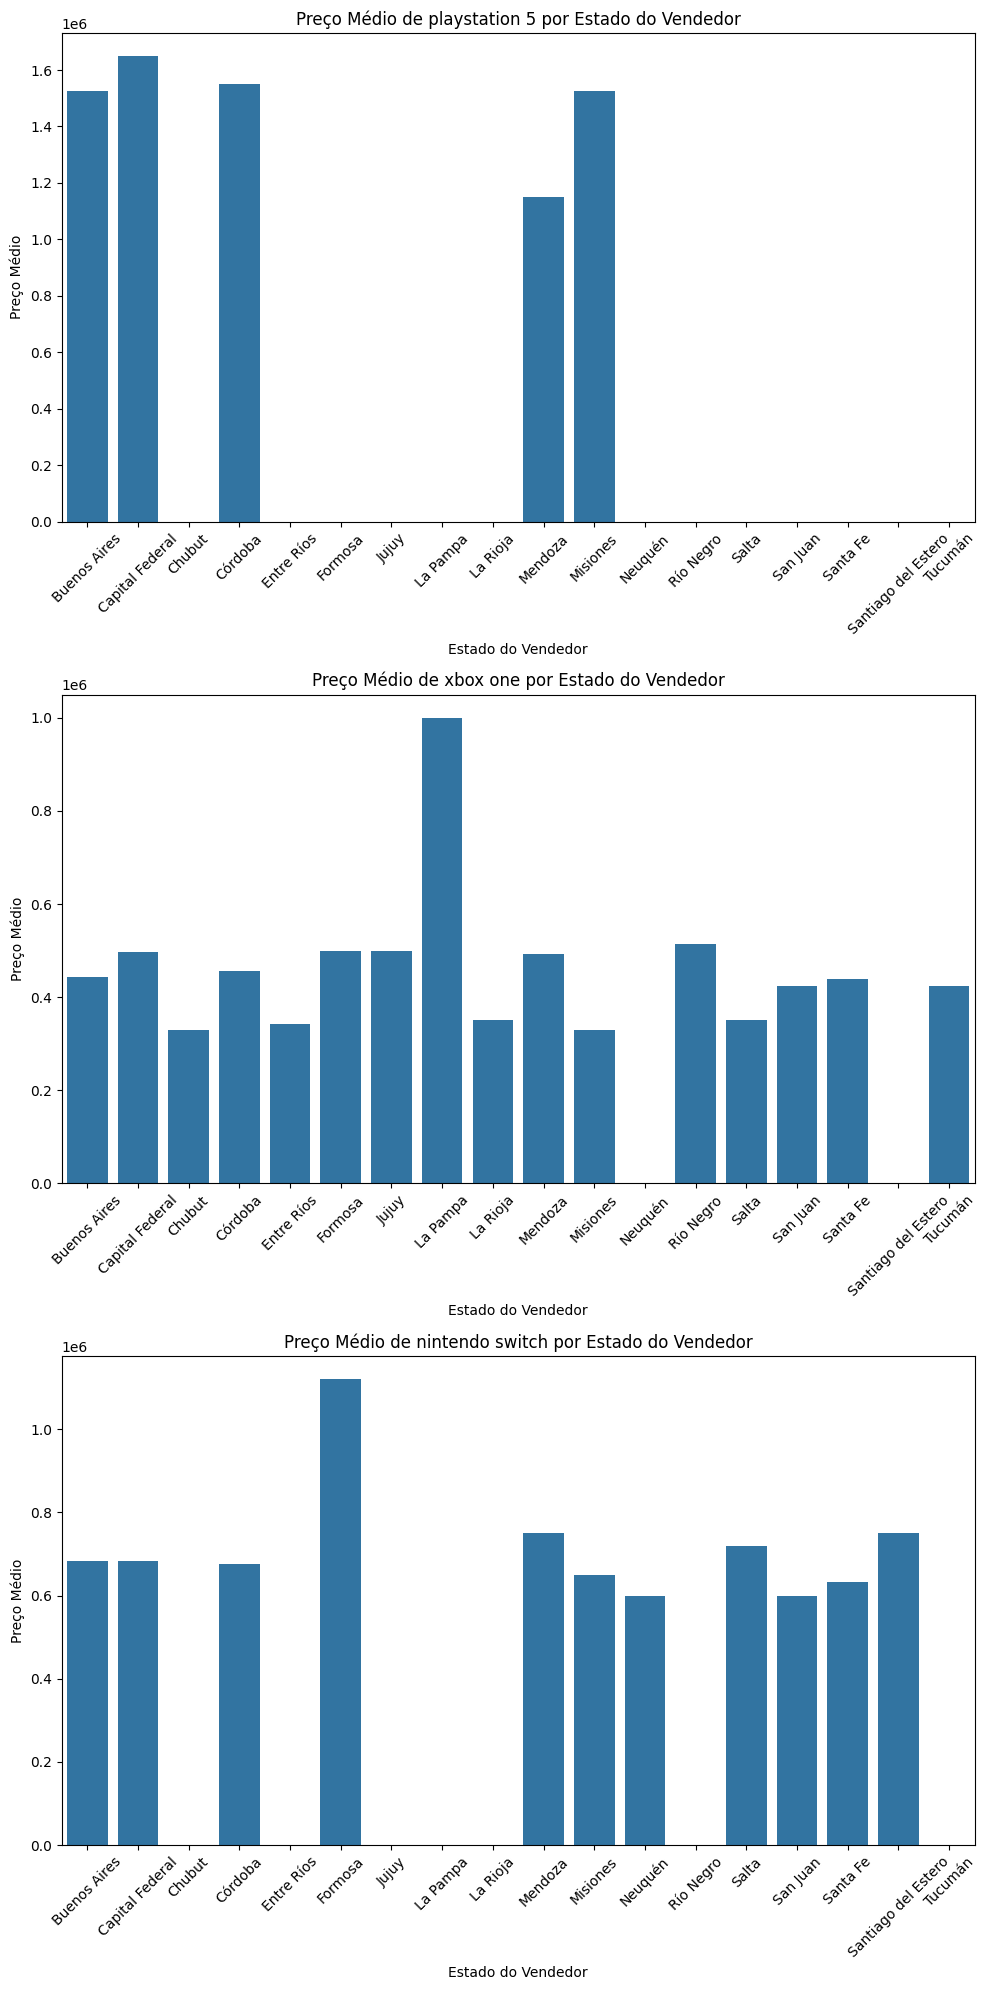

In [53]:
# Calcular as medidas simples por search_term
medidas_simples = df.groupby('search_term').agg(
    count_id=('id', 'count'),
    avg_price=('price', 'mean'),
    sum_initial_quantity=('initial_quantity', 'sum')
).reset_index()

# Calcular a contagem de IDs por seller_state_name
contagem_por_estado = df.groupby('seller_state_name').agg(
    count_id=('id', 'count')
).reset_index()

# Adicionar colunas de preço médio para cada search_term
for term in search_terms:
    avg_price_col = f'avg_price_{term.replace(" ", "_")}'
    avg_price_data = df[df['search_term'] == term].groupby('seller_state_name')['price'].mean().reset_index()
    avg_price_data.rename(columns={'price': avg_price_col}, inplace=True)
    contagem_por_estado = contagem_por_estado.merge(avg_price_data, on='seller_state_name', how='left')

# Exibir as tabelas
print("Tabela agregada por search_term:")
print(medidas_simples)

print("\nTabela agregada por seller_state_name:")
print(contagem_por_estado)

# Criar uma figura para os gráficos de medidas simples
fig, axes = plt.subplots(4, 1, figsize=(10, 20))  # Corrigido para 4 subplots

# Gráfico de contagem de IDs por search_term
sns.barplot(x='search_term', y='count_id', data=medidas_simples, ax=axes[0])
axes[0].set_title('Contagem de IDs por Termo de Busca')
axes[0].set_xlabel('Termo de Busca')
axes[0].set_ylabel('Contagem de IDs')

# Gráfico de preço médio por search_term
sns.barplot(x='search_term', y='avg_price', data=medidas_simples, ax=axes[1])
axes[1].set_title('Preço Médio por Termo de Busca')
axes[1].set_xlabel('Termo de Busca')
axes[1].set_ylabel('Preço Médio')

# Gráfico de soma de initial_quantity por search_term
sns.barplot(x='search_term', y='sum_initial_quantity', data=medidas_simples, ax=axes[2])
axes[2].set_title('Soma de Initial Quantity por Termo de Busca')
axes[2].set_xlabel('Termo de Busca')
axes[2].set_ylabel('Soma de Initial Quantity')

# Gráfico de contagem de IDs por seller_state_name
sns.barplot(x='seller_state_name', y='count_id', data=contagem_por_estado, ax=axes[3])
axes[3].set_title('Contagem de IDs por Estado do Vendedor')
axes[3].set_xlabel('Estado do Vendedor')
axes[3].set_ylabel('Contagem de IDs')
axes[3].tick_params(axis='x', rotation=45)  # Rotacionar os rótulos do eixo x para melhor visualização

plt.tight_layout()
plt.show()

# Criar uma figura para os gráficos de avg_price por seller_state_name para cada search_term
fig, axes = plt.subplots(len(search_terms), 1, figsize=(10, 20))

for i, term in enumerate(search_terms):
    avg_price_col = f'avg_price_{term.replace(" ", "_")}'
    sns.barplot(x='seller_state_name', y=avg_price_col, data=contagem_por_estado, ax=axes[i])
    axes[i].set_title(f'Preço Médio de {term} por Estado do Vendedor')
    axes[i].set_xlabel('Estado do Vendedor')
    axes[i].set_ylabel('Preço Médio')
    axes[i].tick_params(axis='x', rotation=45)  # Rotacionar os rótulos do eixo x para melhor visualização

plt.tight_layout()
plt.show()
